In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from dataloaders import data_setup, engine
from torch import nn
from torchvision import transforms
from torchinfo import summary


In [3]:
torch.cuda.empty_cache()

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

Before we can start to use **transfer learning**, we will set up the dataset into DataLoaders

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
path = "S:/galaxydata/"
data_path = Path(path)
image_path = data_path / "data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")


S:\galaxydata\data directory exists.


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders



In [7]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x162f8fad700>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

## Getting a pretrained model


Here we use the base Vision Transformer Architecture from the <i><b>An Image is Worth 16x16 Words</i></b> paper

In [9]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = None
model = torchvision.models.vit_b_16(weights = weights, progress = False).to(device)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Getting a summary of our model with `torchinfo.summary()`

We use torchinfo to learn more about the model we are using:
To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
input_size = (32, 3, 224, 224)
summary(model=model, 
        input_size= input_size, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000] 768        True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    True
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_

### Freezing the base model and changing the output layer to suit our needs



In [12]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.encoder.parameters():
    param.requires_grad = True

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [15]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size= input_size, # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 9]    768        True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    True
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_

In [17]:
import torchinfo 
torchinfo.summary(model, input_size= input_size)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 9]                   768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-7             

## Train model



In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [19]:
for param in model.encoder.parameters():
    print(param)

Parameter containing:
tensor([[[-0.0024,  0.0106, -0.0253,  ..., -0.0142,  0.0248, -0.0117],
         [-0.0110,  0.0364, -0.0029,  ...,  0.0058, -0.0056,  0.0157],
         [-0.0209, -0.0381,  0.0025,  ..., -0.0213,  0.0042,  0.0259],
         ...,
         [-0.0109,  0.0071,  0.0151,  ...,  0.0003,  0.0080, -0.0007],
         [-0.0343,  0.0057,  0.0202,  ..., -0.0098, -0.0045, -0.0099],
         [-0.0091, -0.0136, -0.0002,  ..., -0.0013,  0.0064, -0.0352]]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

Parameter containing:
tensor([ 7.3289e-07, -1.8748e-07, -2.0395e-07,  ...,  2.7682e-07,
        -1.7146e-07,  2.5399e-07], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0069,  0.0191, -0.0096,  ..., -0.0289,  0.0052, -0.0294],
        [ 0.0074,  0.0059, -0.0008,  ..., -0.0318,  0.0086,  0.0184],
        [-0.0255, -0.0191, -0.0127,  ..., -0.0132,  0.0251,  0.0305],
        ...,
        [ 0.0076,  0.0160,  0.0037,  ...,  0.0345,  0.0285, -0.0158],
        [ 0.0303,  0.0289, -0.0337,  ...,  0.0223, -0.0142, -0.0205],
        [ 0.0135, -0.0238, -0.0383,  ...,  0.0030,  0.0381,  0.0325]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.7537e-06, -8.6073e-07, -3.2235e-07,  5.0257e-07,  5.5291e-07,
        -2.2288e-06, -4.5155e-07,  2.5252e-07, -7.1853e-07,  1.7942e-07,
         2.2172e-07, -1.2267e-06, -9.4601e-07,  9.8705e-07,  6.1432e-07,
        -6.5112e-07, -5.2824e-07, -4.9671e-08,  1.3635e-06, -2.4002e-06,
        -2.0456e-07, -1.45

Parameter containing:
tensor([ 1.9767e-06, -1.4283e-06, -4.6825e-07,  8.7243e-08, -1.1904e-06,
        -6.7690e-07, -4.4205e-07,  7.5583e-07,  5.4818e-07,  1.5158e-06,
        -1.6044e-06, -1.6442e-06,  3.1328e-07, -1.2616e-06,  3.6941e-07,
         7.2635e-07,  1.8653e-07, -1.0372e-06,  1.5104e-06, -1.6441e-06,
        -2.8925e-07,  7.7359e-07,  7.0398e-07, -4.6681e-07,  9.9687e-07,
         6.6253e-07, -6.1311e-07, -6.5570e-07, -1.1725e-07,  1.1709e-06,
        -1.9233e-06,  1.3737e-06,  1.2009e-06,  1.3074e-07, -8.4136e-07,
        -1.2577e-06,  6.4932e-07,  1.6780e-06,  2.1495e-06,  1.1856e-06,
         8.4594e-07, -7.9279e-08, -4.0001e-07, -1.9741e-06,  5.8313e-07,
        -1.0634e-07, -1.4368e-06,  8.3511e-07, -2.0538e-06, -1.0995e-08,
         6.4877e-07,  1.8459e-07,  1.1108e-06,  7.3056e-07,  5.6390e-07,
        -5.4337e-07, -1.6633e-06,  1.3097e-06,  1.2524e-06, -1.2980e-06,
         5.9386e-07, -1.1672e-06, -1.1803e-07, -9.7905e-07,  2.8071e-06,
        -1.2329e-06,  5.6226e

Parameter containing:
tensor([-1.3167e-06, -8.7091e-08,  2.9048e-07,  4.0343e-08,  3.7898e-08,
        -8.0746e-07, -1.2707e-07,  1.8109e-07, -1.8966e-06,  7.4643e-07,
        -6.6930e-08, -7.9073e-07, -1.1166e-06,  1.1542e-06, -9.0937e-08,
         2.0764e-06,  1.5820e-06, -3.9202e-07,  6.5012e-07, -6.2185e-08,
        -5.9797e-07,  2.6514e-07, -1.9547e-07, -1.7501e-06, -1.7456e-07,
         1.4653e-07,  6.2378e-07, -1.1153e-06, -6.9239e-07,  4.8084e-07,
         5.2684e-07,  8.1980e-07,  9.4939e-08,  4.2140e-07, -5.5432e-07,
        -2.2889e-06,  3.5425e-07,  1.3054e-07, -8.7772e-07,  7.7634e-07,
         1.5374e-07,  8.0301e-08, -1.2039e-06, -2.3960e-07,  1.0057e-06,
         4.1006e-07,  2.4210e-08,  1.0163e-06,  2.1896e-07, -1.1066e-07,
         7.8104e-07, -1.5165e-06, -5.6339e-07,  6.6056e-07, -6.7793e-07,
        -8.5995e-07,  5.1599e-07, -1.0651e-08, -6.0330e-07, -1.6845e-06,
         1.3274e-06, -1.1265e-06,  2.9985e-07,  6.9352e-07,  1.6463e-06,
        -7.8915e-07,  4.1904e

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([ 5.7976e-09,  7.2932e-07,  1.0633e-06, -2.6283e-07, -1.2159e-06,
         3.0021e-07, -1.8913e-06,  1.7245e-06, -1.6023e-06,  9.7975e-07,
         1.0309e-06, -1.5686e-07, -1.8833e-06, -6.8968e-07, -2.4126e-06,
         1.4393e-06, -3.3234e-08,  5.1496e-07,  4.1625e-07, -4.4483e-07,
         5.4017e-07, -7.0929e-07,  7.6760e-07,  1.1754e-06,  1.5266e-07,
        -3.9937e-07, -9.1399e-08,  6.6675e-07, -1.6193e-06, -4.0268e-07,
         1.2913e-06, -5.3114e-07,  4.9120e-08, -1.1216e-06,  1.0726e-06,
         8.5638e-07,  3.3245e-07, -3.0294e-06, -1.4170e-06, -1.7317e-07,
         3.4550e-07,  4.4173e-08, -1.4750e-07, -7.8750e-07,  2.2510e-06,
        -5.3984e-09,  1.6824e-07,  1.3446e-06, -6.2305e-07,  6.9592e-07,
         2.7207e-07, -1.0820e-06,  1.5435e-06,  3.4242e-07, -6.8813e-08,
         4.1256e-07,  1.4960e-06, -5.2026e-08, -7.6592e-07, -7.1718e-07,
         1.0128e-09, -8.8573e-07, -3.4942e-07,  3.9846e-07,  1.1190e-06,
        -1.7449e-06, -7.1262e

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

In [20]:
# Set the random seeds
torch.manual_seed(50)
torch.cuda.manual_seed(50)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       patience=3,
                       delta=0.05,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {(end_time-start_time)/60:.3f} minutes")
print(f"[INFO] Total training time: {(end_time-start_time)/3600:.3f} hours")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7336 | train_acc: 0.3564 | test_loss: 1.4101 | test_acc: 0.5034 | min_test_loss: 1.4101 | 
Epoch: 2 | train_loss: 1.2775 | train_acc: 0.5467 | test_loss: 1.1581 | test_acc: 0.6000 | min_test_loss: 1.1581 | 
Epoch: 3 | train_loss: 1.1091 | train_acc: 0.6119 | test_loss: 1.0820 | test_acc: 0.6175 | min_test_loss: 1.0820 | 
Epoch: 4 | train_loss: 1.0316 | train_acc: 0.6431 | test_loss: 1.1488 | test_acc: 0.6001 | min_test_loss: 1.0820 | 
Epoch: 5 | train_loss: 0.9862 | train_acc: 0.6555 | test_loss: 1.0654 | test_acc: 0.6378 | min_test_loss: 1.0654 | 
Epoch: 6 | train_loss: 0.9462 | train_acc: 0.6683 | test_loss: 1.0409 | test_acc: 0.6399 | min_test_loss: 1.0409 | 
Epoch: 7 | train_loss: 0.9142 | train_acc: 0.6854 | test_loss: 1.0294 | test_acc: 0.6480 | min_test_loss: 1.0294 | 
Epoch: 8 | train_loss: 0.8828 | train_acc: 0.6924 | test_loss: 0.9720 | test_acc: 0.6561 | min_test_loss: 0.9720 | 
Epoch: 9 | train_loss: 0.8628 | train_acc: 0.6986 | test_loss: 1.0064 | 

## Evaluate model by plotting loss curves

We can plot the loss curves using the `plot_loss_curves` function from the `helper_functions.py`script 

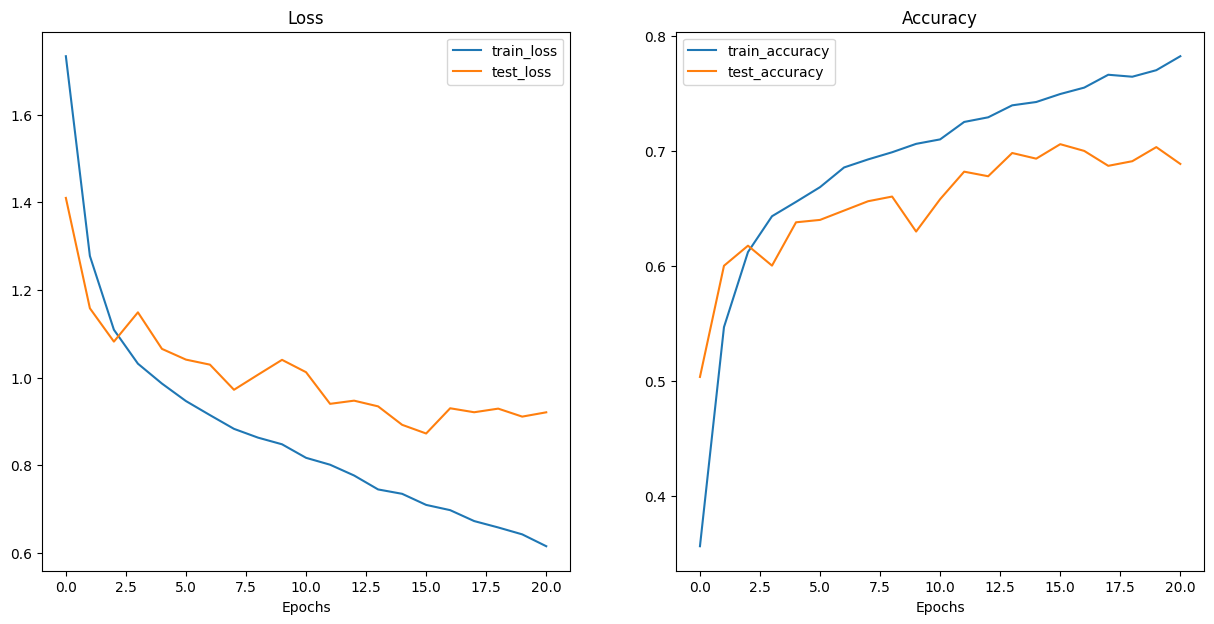

In [21]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [22]:
model_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/vit_scratch.pth"
engine.save_model(model, model_path)

results_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/results_scratch.npy"
engine.save_results(results, results_path)